# Using MTA exit-entry data to estimate foot traffic at pharmacies

Besides wreaking havoc on public health systems globally, the COVID-19 pandemic has fundamentally changed city density patterns. To prevent overhead losses from unnecessary rents, retail chains across America have been considering closing a number of retail locations in previously-dense downtown locations. 

In this notebook, I use the MTA entry and exit data, OpenRouteService API and geopandas to estimate foot traffic at a number of Duane Reade locations in lower Manhattan. This calculation could hopefully be used by company executives in their decisions to potentially close a certain number of stores.

In [1]:
# Import env variable API key
from dotenv import dotenv_values
config = dotenv_values(".env")
API_KEY = config["API_KEY"]
OSR_TOKEN = config["OSR_TOKEN"]

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

import glob
import json
import requests
from geojson import Feature, Point, FeatureCollection, Polygon
from shapely import wkt

import folium
from openrouteservice import client
from datetime import datetime 

drlocations = pd.read_csv('/Users/joycetagal/GitHub/metis-eda/drlocations_new.csv')
station_daily_locations = pd.read_csv('station_daily_locs.csv')

In [3]:
from mtafunctions import *

In [4]:
station_daily_locations = station_daily_locations.drop('Unnamed: 0', axis=1)
station_daily_locations.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,NAME,URL,OBJECTID,the_geom,LINE,NOTES
0,1 AV,2020-12-26,1910414.0,2649351.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times
1,1 AV,2020-12-27,2350.0,4398.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times
2,1 AV,2020-12-28,4897.0,7508.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times
3,1 AV,2020-12-29,5420.0,8066.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times
4,1 AV,2020-12-30,5374.0,8135.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times


In [5]:
drlocations.head()

,store_name,address,lat,lng
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",40.713008,-74.007821
1,Duane Reade,"305 BROADWAY, NEW YORK, NY 10007",40.715479,-74.005545
2,Duane Reade,"17 JOHN ST NEW YORK, NY 10038",40.709970,-74.008741
3,Duane Reade,"185 GREENWICH ST, NEW YORK, NY 10007",40.711566,-74.011426
4,Duane Reade,"200 WATER ST, NEW YORK, NY 10038",40.707256,-74.004805


In [6]:
drlocations.shape[0]

31

Here we select only 31 DR locations in lower Manhattan in order to perform this analysis. However, given the opportunity this analysis can be done on a greater number of locations.

In [7]:
# Remove daily data from stations for now
station_locations = station_daily_locations.groupby(['STATION']).first().reset_index()[['STATION', 'the_geom']]
station_locations['the_geom'] = gp.GeoSeries.from_wkt(station_locations['the_geom'])
station_locations['lat'] = [x.y for x in station_locations['the_geom']]
station_locations['lng'] = [x.x for x in station_locations['the_geom']]

In [8]:
station_locations.head()

,STATION,the_geom,lat,lng
0,1 AV,POINT (-73.98168 40.73097),40.730975,-73.981681
1,14 ST,POINT (-74.00020 40.73783),40.737826,-74.000201
2,14 ST-UNION SQ,POINT (-73.98995 40.73467),40.734673,-73.989951
3,18 ST,POINT (-73.99787 40.74104),40.741040,-73.997871
4,2 AV,POINT (-73.98994 40.72340),40.723402,-73.989938


In [9]:
station_locations.shape[0]

39

Similarly, I have manually selected 39 MTA stations in the lower Manhattan area to prevent unnecessary analysis.

## Identifying the MTA stations closest to our DR locations

- Turning both dfs into gdfs
- Identifying 5-min walk distance isochrone from each stations
- Identify DRs that intersect the station isochrones using a intersect spatial join


In [263]:
## Turn station_locations into a GDF
import time
clnt = client.Client(key=OSR_TOKEN)
map1 = folium.Map(tiles='Stamen Toner', location=([40.715479, -74.005545]), zoom_start=15)
params_iso = {'profile': 'foot-walking', # Walking distance
              'range': [300], #300/60 = 5 mins walking
              'attributes': ['total_pop']
             }

l_dfs = []
for station, the_geom, lat, lng in station_locations.values:
    point = [lng, lat]
    params_iso['locations'] = [point]
    #print(params_iso)
    iso = clnt.isochrones(**params_iso) # Call ORS API Isochrones service
    
    for feature in iso['features']:
        feature['properties']['station'] = station
   
    gdf = gp.GeoDataFrame.from_features(iso)
    l_dfs.append(gdf)
    time.sleep(5) # Avoid API rate warning
    
    folium.features.GeoJson(iso).add_to(map1)
    
    folium.map.Marker(list(reversed(point)), # reverse coords due to weird folium lat/lon syntax
                      icon=folium.Icon(color='lightgray',
                                        icon_color='#cc0000',
                                        icon='subway',
                                        prefix='fa',
                                       ),
                      popup=station,
            ).add_to(map1) # Add station locations to map

In [11]:
l_dfs[0]

,geometry,group_index,value,center,total_pop,station
0,"POLYGON ((-73.98620 40.73268, -73.98490 40.729...",0,300.0,"[-73.98167389272662, 40.730984494314676]",15946.0,1 AV


In [12]:
gdf_isochrones = pd.concat(l_dfs)
stations_gdf = gdf_isochrones.merge(station_locations, left_on='station', right_on='STATION')
stations_gdf.head()

,geometry,group_index,value,center,total_pop,station,STATION,the_geom,lat,lng
0,"POLYGON ((-73.98620 40.73268, -73.98490 40.729...",0,300.0,"[-73.98167389272662, 40.730984494314676]",15946.0,1 AV,1 AV,POINT (-73.98168 40.73097),40.730975,-73.981681
1,"POLYGON ((-74.00484 40.73853, -74.00456 40.737...",0,300.0,"[-74.00019962612599, 40.7378254404179]",17342.0,14 ST,14 ST,POINT (-74.00020 40.73783),40.737826,-74.000201
2,"POLYGON ((-73.99414 40.73615, -73.99413 40.736...",0,300.0,"[-73.98992686541507, 40.73467467742633]",18564.0,14 ST-UNION SQ,14 ST-UNION SQ,POINT (-73.98995 40.73467),40.734673,-73.989951
3,"POLYGON ((-74.00223 40.74271, -74.00200 40.741...",0,300.0,"[-73.99787288737437, 40.74104078425342]",16760.0,18 ST,18 ST,POINT (-73.99787 40.74104),40.741040,-73.997871
4,"POLYGON ((-73.99458 40.72422, -73.99249 40.720...",0,300.0,"[-73.98993886973749, 40.723400079786344]",12262.0,2 AV,2 AV,POINT (-73.98994 40.72340),40.723402,-73.989938


In [291]:
## Turn DR locations into GDF
gdf_drlocations = gp.GeoDataFrame(drlocations, geometry=gp.points_from_xy(drlocations.lng, drlocations.lat))
gdf_drlocations['address'] = gdf_drlocations['address'].str.strip().str.split(',').str[0]

In [292]:
gdf_drlocations.head()

,store_name,address,lat,lng,geometry
0,Duane Reade,250 BROADWAY,40.713008,-74.007821,POINT (-74.00782 40.71301)
1,Duane Reade,305 BROADWAY,40.715479,-74.005545,POINT (-74.00554 40.71548)
2,Duane Reade,17 JOHN ST NEW YORK,40.709970,-74.008741,POINT (-74.00874 40.70997)
3,Duane Reade,185 GREENWICH ST,40.711566,-74.011426,POINT (-74.01143 40.71157)
4,Duane Reade,200 WATER ST,40.707256,-74.004805,POINT (-74.00480 40.70726)


In [299]:
for lat, lon, address in zip(gdf_drlocations['lat'], gdf_drlocations['lng'], gdf_drlocations['address']):
    folium.Marker(location=[lat,lon], popup = address, 
                  icon=folium.Icon(icon_color='yellow',
                                   icon = 'plus'),
                 ).add_to(map1)
    

map1

In [15]:
## Spatial join

intersect_gdf = gp.sjoin(gdf_drlocations, stations_gdf, how='left', op='intersects')

In [16]:
intersect_gdf.head()

,store_name,address,lat_left,lng_left,geometry,index_right,group_index,value,center,total_pop,station,STATION,the_geom,lat_right,lng_right
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",40.713008,-74.007821,POINT (-74.00782 40.71301),38.0,0.0,300.0,"[-74.00975707593658, 40.712569225379546]",6930.0,WORLD TRADE CTR,WORLD TRADE CTR,POINT (-74.00974 40.71256),40.712564,-74.009745
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",40.713008,-74.007821,POINT (-74.00782 40.71301),20.0,0.0,300.0,"[-74.00859927785645, 40.7141176081392]",7272.0,CHAMBERS ST,CHAMBERS ST,POINT (-74.00858 40.71411),40.714111,-74.008585
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",40.713008,-74.007821,POINT (-74.00782 40.71301),22.0,0.0,300.0,"[-74.0070230912938, 40.713289968610354]",7309.0,CITY HALL,CITY HALL,POINT (-74.00699 40.71327),40.713272,-74.006986
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",40.713008,-74.007821,POINT (-74.00782 40.71301),18.0,0.0,300.0,"[-74.00414759710878, 40.71304709963104]",5764.0,BROOKLYN BRIDGE,BROOKLYN BRIDGE,POINT (-74.00413 40.71306),40.713065,-74.004131
1,Duane Reade,"305 BROADWAY, NEW YORK, NY 10007",40.715479,-74.005545,POINT (-74.00554 40.71548),20.0,0.0,300.0,"[-74.00859927785645, 40.7141176081392]",7272.0,CHAMBERS ST,CHAMBERS ST,POINT (-74.00858 40.71411),40.714111,-74.008585


This GeoDataFrame shows, for each Duane Reade location, the stations that are within a 5-minute walk distance from it. We can use the dataframe to calculate the estimate foot traffic for each DR location and show the time series over the past year.

Since we don't need the spatial data anymore, I will drop the unnecessary columns and turn the GDF to a simple dataframe.

In [17]:
intersect_df = intersect_gdf[['store_name', 'address', 'total_pop', 'station']]

In [18]:
intersect_df.head()

,store_name,address,total_pop,station
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",6930.0,WORLD TRADE CTR
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",7272.0,CHAMBERS ST
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",7309.0,CITY HALL
0,Duane Reade,"250 BROADWAY, NEW YORK, NY 10007",5764.0,BROOKLYN BRIDGE
1,Duane Reade,"305 BROADWAY, NEW YORK, NY 10007",7272.0,CHAMBERS ST


## Time series foot traffic

Now that we have identified the closest MTA stations to our selected DR locations, we will now perform the following steps:

- Sum entries and exits for stations related to the DRs over time
- Show estimated foot traffic for each DR in the time period
- Clean and remove any obvious outliers/data discrepancies

In [19]:
station_daily_locations.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,NAME,URL,OBJECTID,the_geom,LINE,NOTES
0,1 AV,2020-12-26,1910414.0,2649351.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times
1,1 AV,2020-12-27,2350.0,4398.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times
2,1 AV,2020-12-28,4897.0,7508.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times
3,1 AV,2020-12-29,5420.0,8066.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times
4,1 AV,2020-12-30,5374.0,8135.0,1 AV,http://web.mta.info/nyct/service/,146,POINT (-73.98168087489128 40.73097497580066),L,L-all times


In [162]:
# Merge the two dfs to retain daily entries and exits for the MTA stations surrounding each DR location
dr_daily_traffic = pd.merge(
    intersect_df, 
    station_daily_locations.drop(['NAME', 'URL', 'OBJECTID', 'the_geom', 'LINE', 'NOTES'], axis=1), 
    how='left', left_on='station', right_on='STATION'
)
dr_daily_traffic = dr_daily_traffic.drop('station', axis=1)
dr_daily_traffic.columns = [x.upper().replace('/','_') for x in dr_daily_traffic.columns] # Standardize column names
dr_daily_traffic['DATE'] = pd.to_datetime(dr_daily_traffic.DATE, format="%Y-%m-%d")
dr_daily_traffic = dr_daily_traffic[dr_daily_traffic['DATE'] > pd.to_datetime("01/01/2020", format="%m/%d/%Y")]

In [163]:
dr_daily_traffic.head()

,STORE_NAME,ADDRESS,TOTAL_POP,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS
0,Duane Reade,250 BROADWAY,6930.0,WORLD TRADE CTR,2020-12-26,634167.0,1036558.0
1,Duane Reade,250 BROADWAY,6930.0,WORLD TRADE CTR,2020-12-27,981.0,1142.0
2,Duane Reade,250 BROADWAY,6930.0,WORLD TRADE CTR,2020-12-28,2378.0,2039.0
3,Duane Reade,250 BROADWAY,6930.0,WORLD TRADE CTR,2020-12-29,2399.0,2079.0
4,Duane Reade,250 BROADWAY,6930.0,WORLD TRADE CTR,2020-12-30,2393.0,2163.0


In [164]:
## Sanity check to see how many stations per DR location

(dr_daily_traffic[dr_daily_traffic['DATE'] == '2021-05-15']
 .groupby(['STORE_NAME', 'ADDRESS', 'DATE'])
 .STATION.count()
 .reset_index()
 .sort_values("STATION", ascending=False)).head(5)

,STORE_NAME,ADDRESS,DATE,STATION
9,Duane Reade,250 BROADWAY,2021-05-15,4
12,Duane Reade,37 BROADWAY,2021-05-15,4
17,Duane Reade,67 BROAD ST,2021-05-15,4
8,Duane Reade,185 GREENWICH ST,2021-05-15,3
10,Duane Reade,305 BROADWAY,2021-05-15,3


In [165]:
# Sanity check
dr_daily_traffic[(dr_daily_traffic['DATE'] == '2021-05-15') &
                 (dr_daily_traffic['ADDRESS'].str.contains('GREENWICH'))]

,STORE_NAME,ADDRESS,TOTAL_POP,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS
2272,Duane Reade,185 GREENWICH ST,6812.0,CORTLANDT ST,2021-05-15,3948.0,4154.0
2509,Duane Reade,185 GREENWICH ST,6930.0,WORLD TRADE CTR,2021-05-15,2302.0,4209.0
2746,Duane Reade,185 GREENWICH ST,7272.0,CHAMBERS ST,2021-05-15,7060.0,10552.0
3932,Duane Reade,352 GREENWICH ST,6688.0,FRANKLIN ST,2021-05-15,895.0,908.0


In [166]:
# Sanity check
dr_foottraffic = dr_daily_traffic.groupby(['STORE_NAME', 'ADDRESS', 'DATE'])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index()

In [167]:
# Sanity check
dr_foottraffic[(dr_foottraffic['DATE'] == '2021-05-15') &
                 (dr_foottraffic['ADDRESS'].str.contains('GREENWICH'))]

,STORE_NAME,ADDRESS,DATE,DAILY_ENTRIES,DAILY_EXITS
2035,Duane Reade,185 GREENWICH ST,2021-05-15,13310.0,18915.0
2746,Duane Reade,352 GREENWICH ST,2021-05-15,895.0,908.0


In [168]:
dr_foottraffic['NET_TRAFFIC'] = dr_foottraffic['DAILY_ENTRIES'] - dr_foottraffic['DAILY_EXITS']

In [169]:
dr_foottraffic.head()

,STORE_NAME,ADDRESS,DATE,DAILY_ENTRIES,DAILY_EXITS,NET_TRAFFIC
0,Duane Reade,1 UNION SQUARE SOUTH,2020-12-26,5071993.0,7169072.0,-2097079.0
1,Duane Reade,1 UNION SQUARE SOUTH,2020-12-27,10991.0,14494.0,-3503.0
2,Duane Reade,1 UNION SQUARE SOUTH,2020-12-28,18575.0,23409.0,-4834.0
3,Duane Reade,1 UNION SQUARE SOUTH,2020-12-29,19981.0,24401.0,-4420.0
4,Duane Reade,1 UNION SQUARE SOUTH,2020-12-30,20902.0,26194.0,-5292.0


In [170]:
dr_foottraffic.sort_values(['DATE', 'NET_TRAFFIC'], ascending=True)[:10]

,STORE_NAME,ADDRESS,DATE,DAILY_ENTRIES,DAILY_EXITS,NET_TRAFFIC
948,Duane Reade,125-133 3RD AVE,2020-12-26,5510099.0,7794090.0,-2283991.0
4740,Walgreens,145 4TH AVE,2020-12-26,5510099.0,7794090.0,-2283991.0
0,Duane Reade,1 UNION SQUARE SOUTH,2020-12-26,5071993.0,7169072.0,-2097079.0
4503,Duane Reade,777 AVENUE OF THE AMERICAS,2020-12-26,8017772.0,9892616.0,-1874844.0
1659,Duane Reade,184 5TH AVE,2020-12-26,5573504.0,6880417.0,-1306913.0
4266,Duane Reade,77 7TH AVE,2020-12-26,3546549.0,4666331.0,-1119782.0
3555,Duane Reade,459 BROADWAY,2020-12-26,4058973.0,4827746.0,-768773.0
4977,Walgreens,298 1ST AVE,2020-12-26,1910414.0,2649351.0,-738937.0
3792,Duane Reade,60 SPRING ST,2020-12-26,909057.0,1421883.0,-512826.0
2844,Duane Reade,37 BROADWAY,2020-12-26,4495704.0,5004419.0,-508715.0


We can see here that Boxing Day (26th Dec 2020) is an outlier in terms of net traffic. Let's remove it and begin the data from the 27th of Dec onwards.

In [171]:
dr_foottraffic = dr_foottraffic[dr_foottraffic['DATE'] > '2020-12-26']

In [172]:
dr_foottraffic.sort_values('NET_TRAFFIC', ascending=True)[:10]

,STORE_NAME,ADDRESS,DATE,DAILY_ENTRIES,DAILY_EXITS,NET_TRAFFIC
4623,Duane Reade,777 AVENUE OF THE AMERICAS,2021-04-26,35973.0,458299.0,-422326.0
1779,Duane Reade,184 5TH AVE,2021-04-26,25145.0,443595.0,-418450.0
1947,Duane Reade,185 GREENWICH ST,2021-02-16,14389.0,386626.0,-372237.0
1236,Duane Reade,17 JOHN ST NEW YORK,2021-02-16,4674.0,376651.0,-371977.0
2184,Duane Reade,250 BROADWAY,2021-02-16,15985.0,387951.0,-371966.0
4677,Duane Reade,777 AVENUE OF THE AMERICAS,2021-06-19,34577.0,302920.0,-268343.0
1833,Duane Reade,184 5TH AVE,2021-06-19,26118.0,289687.0,-263569.0
4682,Duane Reade,777 AVENUE OF THE AMERICAS,2021-06-24,86789.0,160710.0,-73921.0
3807,Duane Reade,60 SPRING ST,2021-01-11,13709.0,79978.0,-66269.0
2237,Duane Reade,250 BROADWAY,2021-04-10,102566.0,133975.0,-31409.0


Again, we see that there are several `NET_TRAFFIC` values which are an order of magnitude higher than the rest of the values. We can remove those days, assuming that there was an issue with the counter.

(array([ 126.,  240.,  572.,  753., 1363., 1525.,  227.,    6.,    2.,
           3.]),
 array([-9974. , -8282.2, -6590.4, -4898.6, -3206.8, -1515. ,   176.8,
         1868.6,  3560.4,  5252.2,  6944. ]),
 <BarContainer object of 10 artists>)

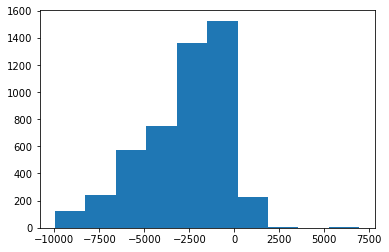

In [230]:
# See what the distribution is across the dataset
%matplotlib inline
plt.hist(dr_foottraffic['NET_TRAFFIC'])

In [231]:
dr_foottraffic = dr_foottraffic[dr_foottraffic['NET_TRAFFIC'] > -10000]
dr_foottraffic = dr_foottraffic[dr_foottraffic['NET_TRAFFIC'] < 20000]

In [232]:
dr_foottraffic.sort_values('NET_TRAFFIC', ascending=False)[:100]

,STORE_NAME,ADDRESS,DATE,DAILY_ENTRIES,DAILY_EXITS,NET_TRAFFIC
1355,Duane Reade,17 JOHN ST NEW YORK,2021-06-15,21954.0,15010.0,6944.0
2520,Duane Reade,305 BROADWAY,2021-05-26,96490.0,90200.0,6290.0
2283,Duane Reade,250 BROADWAY,2021-05-26,100006.0,94479.0,5527.0
4304,Duane Reade,77 7TH AVE,2021-02-03,36653.0,32385.0,4268.0
2066,Duane Reade,185 GREENWICH ST,2021-06-15,37183.0,33338.0,3845.0
...,...,...,...,...,...,...
3105,Duane Reade,4 W 4TH ST,2021-01-20,5024.0,3724.0,1300.0
3097,Duane Reade,4 W 4TH ST,2021-01-12,5148.0,3850.0,1298.0
3169,Duane Reade,4 W 4TH ST,2021-03-25,6103.0,4812.0,1291.0
3114,Duane Reade,4 W 4TH ST,2021-01-29,5277.0,3990.0,1287.0


## Visualize time series of foot traffic

In [305]:
## Plot a single store
single_store = dr_foottraffic[(dr_foottraffic["STORE_NAME"] == "Duane Reade") & 
(dr_foottraffic["ADDRESS"] == "184 5TH AVE")]

single_store.head()

,STORE_NAME,ADDRESS,DATE,DAILY_ENTRIES,DAILY_EXITS,NET_TRAFFIC
1660,Duane Reade,184 5TH AVE,2020-12-27,8702.0,10415.0,-1713.0
1661,Duane Reade,184 5TH AVE,2020-12-28,18851.0,19785.0,-934.0
1662,Duane Reade,184 5TH AVE,2020-12-29,19845.0,21281.0,-1436.0
1663,Duane Reade,184 5TH AVE,2020-12-30,20434.0,21709.0,-1275.0
1664,Duane Reade,184 5TH AVE,2020-12-31,15720.0,17161.0,-1441.0


Text(0.5, 1.0, 'Net Traffic for 184 5th Ave')

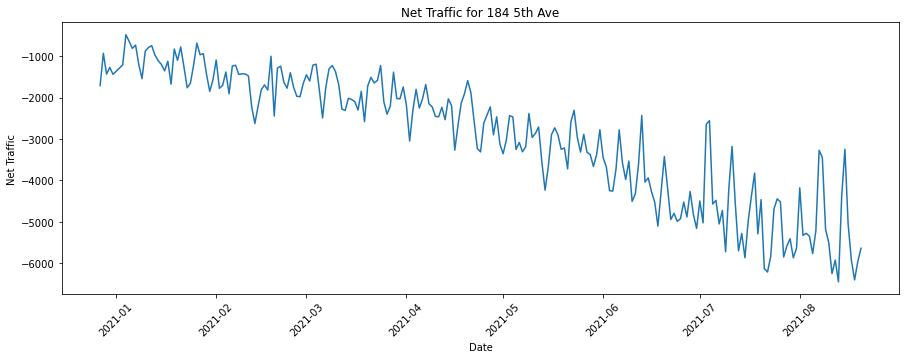

In [306]:
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(single_store['DATE'], single_store['NET_TRAFFIC'])
plt.ylabel('Net Traffic')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Net Traffic for 184 5th Ave')

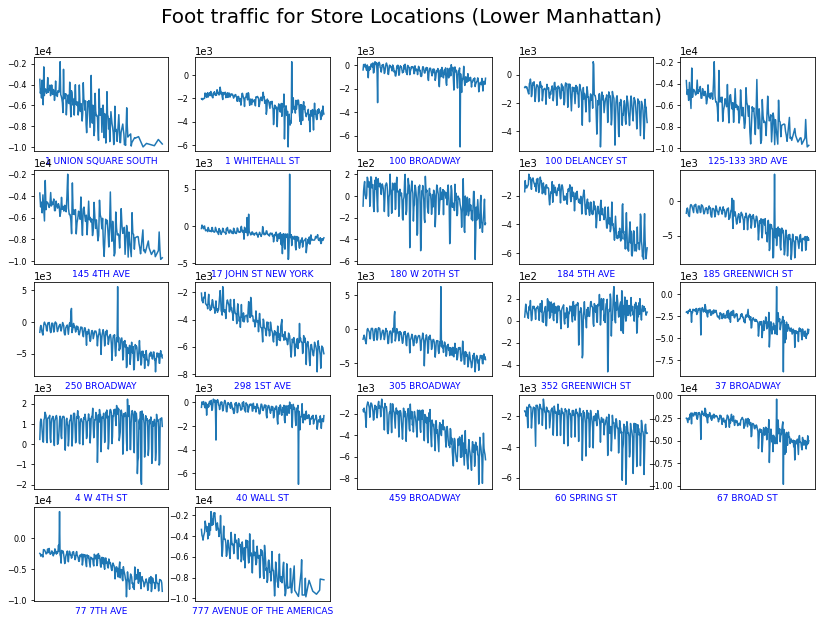

<Figure size 432x288 with 0 Axes>

In [301]:
## Plot all stores timelines in the dataset
%matplotlib inline
a = 5  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))
fig.suptitle('Foot traffic for Store Locations (Lower Manhattan)', fontsize=20, y=0.95)
for i, group in dr_foottraffic.groupby('ADDRESS'):
    plt.subplot(a, b, c)
    plt.title(i, fontsize=9, color='b', y=-0.2)
    plt.plot(group['DATE'], group['NET_TRAFFIC'])
    plt.xticks(ticks=[])
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.tick_params(labelbottom=False, labelsize=8)
    c = c + 1

    
plt.show()
plt.savefig("all_stores.jpg")